In [1]:
import pandas as pd
import numpy as np
import datetime
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2

%matplotlib inline

### Data
---

In [2]:
df = pd.read_csv('./data/combined.csv')

In [3]:
df.head()

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,FIRE_NAME,CAUSE,lat,long,GIS_ACRES
0,2008-07,Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.079570,0.010000,13.164516,no_fire,0.0,34.54,-120.04,0.000000
1,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,SERPENTINE,1.0,38.18,-120.56,176.763400
2,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,POOL 2 - MAIN,10.0,38.18,-120.56,73.444778
3,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,FRENCH,14.0,38.18,-120.56,101.074150
4,2008-07,Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,38.434409,0.068065,14.022581,EVANS,6.0,38.18,-120.56,103.968050


In [4]:
df = df.drop(columns=['FIRE_NAME', 'lat', 'long'])

In [5]:
df['bool'] = (df['GIS_ACRES'] > 0) * 1
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool
0,2008-07,Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0


In [6]:
df['date'] = [x.split('-') for x in df['date']]
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0


In [7]:
df['year'] = [int(x[0]) for x in df['date']]
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool,year
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0,2008


In [8]:
df['month'] = [int(x[1]) for x in df['date']]
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool,year,month
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0,2008,7


In [9]:
df.shape

(10988, 18)

In [10]:
df_dummy = pd.get_dummies(df, columns=['month'])
df.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,q_avghumid,q_sumprecip,sunHour,CAUSE,GIS_ACRES,bool,year,month
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,34.07957,0.01,13.164516,0.0,0.0,0,2008,7


In [11]:
df_dummy.head(1)

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,...,False,False,False,False,True,False,False,False,False,False


In [12]:
# test = ['2008', '07']
# datetime.datetime(int(test[0]), int(test[1]), 1).timestamp()

In [13]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10988 entries, 0 to 10987
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         10988 non-null  object 
 1   county       10988 non-null  object 
 2   maxtempF     10988 non-null  float64
 3   mintempF     10988 non-null  float64
 4   avgtempF     10988 non-null  float64
 5   totalSnow    10988 non-null  float64
 6   humid        10988 non-null  float64
 7   wind         10988 non-null  float64
 8   precip       10988 non-null  float64
 9   q_avgtempF   10988 non-null  float64
 10  q_avghumid   10988 non-null  float64
 11  q_sumprecip  10988 non-null  float64
 12  sunHour      10988 non-null  float64
 13  CAUSE        10988 non-null  float64
 14  GIS_ACRES    10988 non-null  float64
 15  bool         10988 non-null  int64  
 16  year         10988 non-null  int64  
 17  month_1      10988 non-null  bool   
 18  month_2      10988 non-null  bool   
 19  mont

In [14]:
df_dummy.head()

,date,county,maxtempF,mintempF,avgtempF,totalSnow,humid,wind,precip,q_avgtempF,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,"[2008, 07]",Santa Barbara County,89.129032,59.709677,80.548387,0.0,41.451613,7.354839,0.0,72.937634,...,False,False,False,False,True,False,False,False,False,False
1,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,False,False,False,False,True,False,False,False,False,False
2,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,False,False,False,False,True,False,False,False,False,False
3,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,False,False,False,False,True,False,False,False,False,False
4,"[2008, 07]",Calaveras County,96.419355,51.290323,87.032258,0.0,33.580645,5.387097,0.0,65.217204,...,False,False,False,False,True,False,False,False,False,False


### Classification
---

In [15]:
X = df_dummy.drop(columns=['GIS_ACRES', 'date', 'q_avgtempF', 'q_avghumid', 'q_sumprecip', 'maxtempF', 'mintempF', 'CAUSE', 'bool', 'county'])
y = df_dummy['bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [16]:
df['bool'].value_counts(normalize=True) #Unbalanced data

bool
0    0.638424
1    0.361576
Name: proportion, dtype: float64

## 羅吉斯回歸

In [17]:
from sklearn.linear_model import LogisticRegression

# 方法四：使用 class_weight='balanced'
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

# 檢查訓練與測試分數
print("Train score:", log_reg.score(X_train, y_train))
print("Test score:", log_reg.score(X_test, y_test))


Train score: 0.7434663892861787
Test score: 0.7573551713679102


C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


###  羅吉斯回歸-混淆矩陣

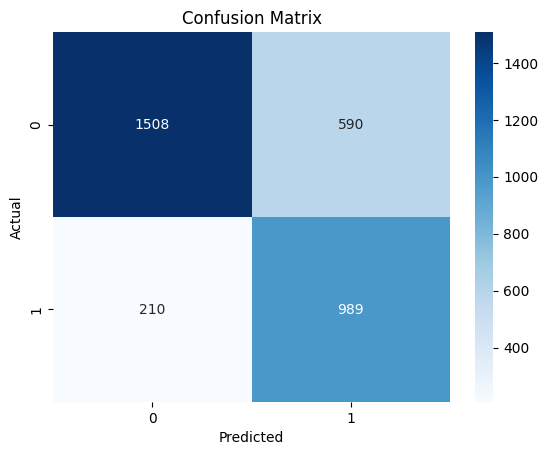

Classification Report:

              precision    recall  f1-score   support

           0     0.8778    0.7188    0.7904      2098
           1     0.6263    0.8249    0.7120      1199

    accuracy                         0.7574      3297
   macro avg     0.7521    0.7718    0.7512      3297
weighted avg     0.7863    0.7574    0.7619      3297



In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = log_reg.predict(X_test)

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# classification report（包含 precision, recall, f1-score）
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

In [19]:
pd.set_option('display.max_row', None)

In [20]:
coef_df = pd.DataFrame(log_reg.coef_, columns=X.columns)
coef_df.T.sort_values(by=0, ascending=False).head(77)

,0
month_8,1.088163
month_11,0.647992
month_9,0.551165
sunHour,0.542979
month_12,0.468268
month_7,0.265440
month_10,0.086014
totalSnow,0.009221
year,-0.001591
avgtempF,-0.006095


In [21]:
log_reg.coef_

array([[-0.00609488,  0.00922107, -0.02593307, -0.26969065, -0.43966367,
         0.54297853, -0.00159086, -0.5240136 , -0.91722015, -0.59754993,
        -0.37368111, -0.45151369, -0.27830824,  0.2654397 ,  1.08816347,
         0.55116498,  0.08601395,  0.64799208,  0.46826796]])

- 這段程式碼是在對特徵進行標準化（`Standardization）`，讓每個特徵轉換成平均值為 0、標準差為 `1 的分佈，這對像是 Logistic Regression、SVM、KNN` 等模型尤其重要。

In [22]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## KNN

Train Accuracy: 0.9986997789624236
Test Accuracy: 0.8492569002123143


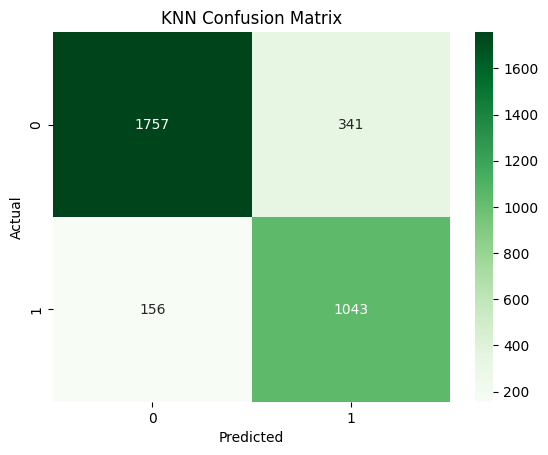

Classification Report:

              precision    recall  f1-score   support

           0     0.9185    0.8375    0.8761      2098
           1     0.7536    0.8699    0.8076      1199

    accuracy                         0.8493      3297
   macro avg     0.8360    0.8537    0.8418      3297
weighted avg     0.8585    0.8493    0.8512      3297



In [23]:

#KNN 
# N=3
#Train Accuracy: 0.9986997789624236
#Test Accuracy: 0.8495602062481044

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train_sc, y_train)

# 預測
y_pred_knn = knn.predict(X_test_sc)

# Train / Test accuracy
print("Train Accuracy:", knn.score(X_train_sc, y_train))
print("Test Accuracy:", knn.score(X_test_sc, y_test))

# 混淆矩陣
cm2 = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Confusion Matrix")
plt.show()

# classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_knn, digits=4))

## RF 隨機森林

Train Accuracy: 0.969054739305682
Test Accuracy: 0.872914771003943


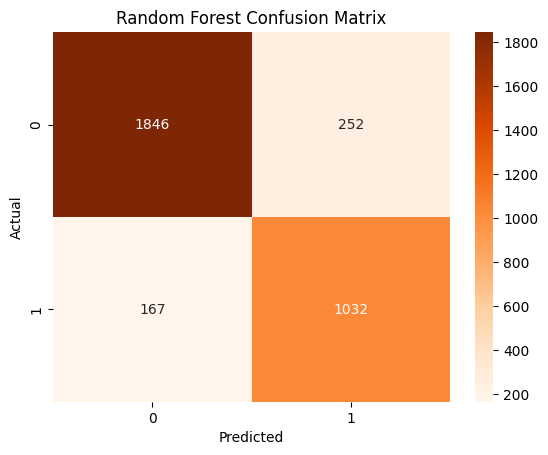

Classification Report:

              precision    recall  f1-score   support

           0     0.9170    0.8799    0.8981      2098
           1     0.8037    0.8607    0.8313      1199

    accuracy                         0.8729      3297
   macro avg     0.8604    0.8703    0.8647      3297
weighted avg     0.8758    0.8729    0.8738      3297



In [24]:
#Random Forest 隨機森林

#Train Accuracy: 0.9837472370302951
#Test Accuracy: 0.8823172581134364

rf = RandomForestClassifier(n_estimators=150, max_depth=15, class_weight='balanced')
rf.fit(X_train, y_train)

# 預測
y_pred_rf = rf.predict(X_test)

# 準確率
print("Train Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy:", rf.score(X_test, y_test))

# 混淆矩陣
cm3 = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

# classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_rf, digits=4))

In [25]:
rf.feature_importances_

array([0.20085815, 0.0190429 , 0.18804576, 0.12484834, 0.10171827,
       0.22421439, 0.0621815 , 0.00455948, 0.0028742 , 0.00338653,
       0.00645021, 0.00677605, 0.00490163, 0.01848118, 0.00975561,
       0.00810364, 0.0066967 , 0.0033787 , 0.00372676])

In [26]:
feature_df = pd.DataFrame(rf.feature_importances_, index=X.columns)
feature_df.sort_values(by=0, ascending=False)

,0
sunHour,0.224214
avgtempF,0.200858
humid,0.188046
wind,0.124848
precip,0.101718
year,0.062181
totalSnow,0.019043
month_7,0.018481
month_8,0.009756
month_9,0.008104


In [27]:
log_reg.predict(X_test)
knn.predict(X_test)
rf.predict(X_test)

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


array([1, 0, 0, ..., 0, 0, 0])

In [28]:
pred_df = pd.DataFrame(columns=['log_reg', 'knn', 'rf'])
pred_df['log_reg'] = log_reg.predict(X_test)
pred_df['knn'] = knn.predict(X_test)
pred_df['rf'] = rf.predict(X_test)
pred_df['ensemble'] = (pred_df.sum(axis=1)/3).round(0)
pred_df.head()

C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


,log_reg,knn,rf,ensemble
0,1,0,1,1.0
1,0,0,0,0.0
2,0,0,0,0.0
3,1,0,1,1.0
4,0,0,0,0.0


In [29]:
metrics.accuracy_score(pred_df['ensemble'], y_test)

0.8086138914164391

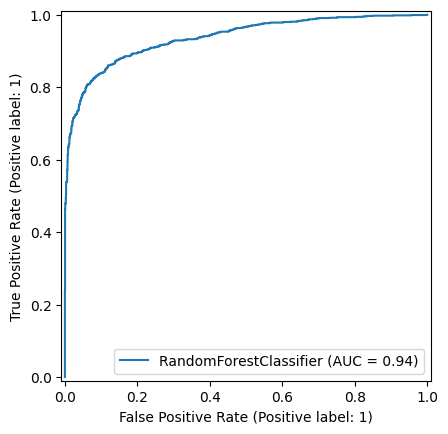

In [30]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rf, X_test, y_test)

## DNN

In [ ]:
n_input = X_train.shape[1]

model = Sequential()
model.add(BatchNormalization())
model.add(Dense(256, input_shape=(n_input,), activation='relu'))
model.add(Dropout(0.1))  # 增加 Dropout 率，避免過擬合
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))  # Dropout 率可根據需要進行調整
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))  # Dropout 率可根據需要進行調整
model.add(Dense(1, activation='sigmoid'))


# 模型optimizer 和 learning rate


initial_lr = 0.001
from tensorflow.keras.optimizers import schedules
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=lr_schedule)

model.compile(loss='bce', optimizer=optimizer, metrics=['acc', 'Recall', 'Precision'])

# EarlyStopping: 根據 val_loss 停止訓練
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# ModelCheckpoint: 儲存最佳模型
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('./models_temp/DNN_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1)

model.evaluate(X_test, y_test)

Epoch 1/100


C:\Users\ygz08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - Precision: 0.6267 - Recall: 0.5628 - acc: 0.7180 - loss: 0.5222 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_acc: 0.6363 - val_loss: 4.6739
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.6452 - Recall: 0.6809 - acc: 0.7548 - loss: 0.4718 - val_Precision: 0.5347 - val_Recall: 0.8807 - val_acc: 0.6779 - val_loss: 0.6431
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.6505 - Recall: 0.7139 - acc: 0.7601 - loss: 0.4696 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_acc: 0.6363 - val_loss: 1.4067
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.6793 - Recall: 0.6766 - acc: 0.7663 - loss: 0.4725 - val_Precision: 0.3980 - val_Recall: 0.9700 - val_acc: 0.4556 - val_loss: 1.2147
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.6715 - Recall: 0.6667 - acc: 0.7632 - loss: 0.4713 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_acc: 0.6363 - val_loss: 

[0.42388156056404114,
 0.8371246457099915,
 0.8273561596870422,
 0.7503781914710999]

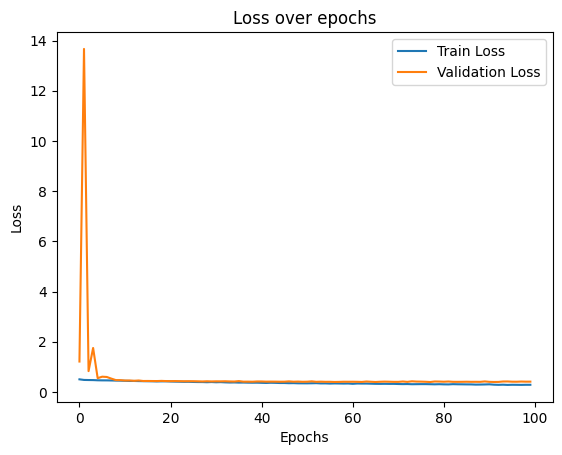

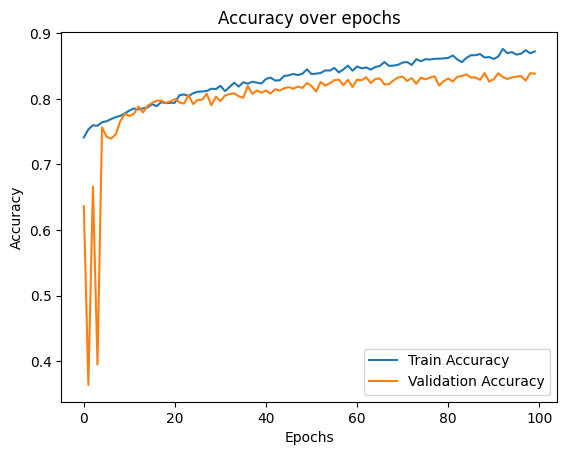

In [32]:
import matplotlib.pyplot as plt

# Loss 曲線
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Accuracy 曲線
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


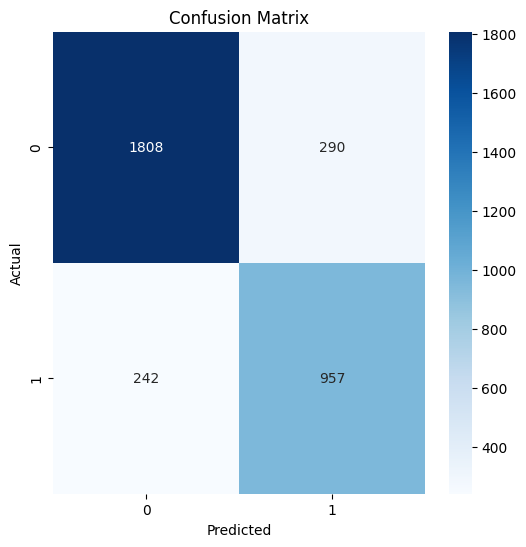

Classification Report:

              precision    recall  f1-score   support

           0     0.8820    0.8618    0.8717      2098
           1     0.7674    0.7982    0.7825      1199

    accuracy                         0.8386      3297
   macro avg     0.8247    0.8300    0.8271      3297
weighted avg     0.8403    0.8386    0.8393      3297



In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 預測結果
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)  # 轉換為二分類結果

# 計算混淆矩陣
cm_f = confusion_matrix(y_test, y_pred_class)

# 繪製混淆矩陣
plt.figure(figsize=(6, 6))
sns.heatmap(cm_f, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_class, digits=4))

In [34]:
#history_df = pd.DataFrame(history.history)
#history_df.sort_values(by='acc', ascending=False)

## Attention Mechanism

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, MultiHeadAttention, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.models import Model

n_input = X_train.shape[1]
# Model
# 定義模型
input_layer = Input(shape=(n_input,))
x = BatchNormalization()(input_layer)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
# Reshape 輸入，以便進行注意力機制（將它變成三維張量）
x = Reshape((1, 128))(x)  # 假設每個樣本有 128 個特徵，這樣就會有 1 個時間步
# 添加多頭注意力層
x_attention = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)  # query, key 和 value 都是 x
x_attention = Dropout(0.1)(x_attention)
# 將注意力層的輸出展平
x_flattened = Flatten()(x_attention)
# 經過展平後的處理
x = Dense(128, activation='relu')(x_flattened)
x = Dropout(0.1)(x)
output = Dense(1, activation='sigmoid')(x)


# Model
model = Model(inputs=input_layer, outputs=output)
model.summary()
# 模型optimizer 和 learning rate
initial_lr = 0.001
from tensorflow.keras.optimizers import schedules
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=lr_schedule)

model.compile(loss='bce', optimizer=optimizer, metrics=['acc', 'Recall', 'Precision'])
# EarlyStopping: 根據 val_loss 停止訓練
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# ModelCheckpoint: 儲存最佳模型
checkpoint = ModelCheckpoint('./models_temp/attention_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1, callbacks=[early_stop, checkpoint])

# 評估模型
model.evaluate(X_test, y_test)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19)        │         76 │ input_layer_4[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │      2,560 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 128)       │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 128)    │          0 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 128)    │     66,048 │ reshape_2[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 1, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 128)       │          0 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     16,512 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 128)       │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │        129 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,325 (333.30 KB)

 Trainable params: 85,287 (333.15 KB)

 Non-trainable params: 38 (152.00 B)

Epoch 1/100
57/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.5821 - Recall: 0.4863 - acc: 0.6927 - loss: 0.5502
Epoch 1: val_loss improved from inf to 13.11737, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - Precision: 0.5851 - Recall: 0.4996 - acc: 0.6956 - loss: 0.5475 - val_Precision: 0.3637 - val_Recall: 1.0000 - val_acc: 0.3637 - val_loss: 13.1174
Epoch 2/100
52/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6603 - Recall: 0.6588 - acc: 0.7518 - loss: 0.4878
Epoch 2: val_loss improved from 13.11737 to 4.10987, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - Precision: 0.6608 - Recall: 0.6574 - acc: 0.7522 - loss: 0.4871 - val_Precision: 0.3637 - val_Recall: 1.0000 - val_acc: 0.3637 - val_loss: 4.1099
Epoch 3/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6518 - Recall: 0.7045 - acc: 0.7562 - loss: 0.4857
Epoch 3: val_loss improved from 4.10987 to 2.71797, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6530 - Recall: 0.7021 - acc: 0.7566 - loss: 0.4847 - val_Precision: 0.3679 - val_Recall: 1.0000 - val_acc: 0.3752 - val_loss: 2.7180
Epoch 4/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6389 - Recall: 0.6994 - acc: 0.7541 - loss: 0.4787
Epoch 4: val_loss improved from 2.71797 to 0.61482, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6400 - Recall: 0.6998 - acc: 0.7540 - loss: 0.4793 - val_Precision: 0.8193 - val_Recall: 0.1134 - val_acc: 0.6685 - val_loss: 0.6148
Epoch 5/100
57/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6729 - Recall: 0.6296 - acc: 0.7576 - loss: 0.4712
Epoch 5: val_loss did not improve from 0.61482
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6724 - Recall: 0.6308 - acc: 0.7575 - loss: 0.4713 - val_Precision: 0.4702 - val_Recall: 0.9141 - val_acc: 0.5942 - val_loss: 0.7900
Epoch 6/100
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6712 - Recall: 0.7092 - acc: 0.7663 - loss: 0.4770
Epoch 6: val_loss improved from 0.61482 to 0.54554, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6707 - Recall: 0.7073 - acc: 0.7659 - loss: 0.4767 - val_Precision: 0.6012 - val_Recall: 0.7681 - val_acc: 0.7304 - val_loss: 0.5455
Epoch 7/100
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6589 - Recall: 0.6730 - acc: 0.7666 - loss: 0.4675
Epoch 7: val_loss did not improve from 0.54554
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6594 - Recall: 0.6759 - acc: 0.7664 - loss: 0.4677 - val_Precision: 0.5591 - val_Recall: 0.7731 - val_acc: 0.6958 - val_loss: 0.6124
Epoch 8/100
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6514 - Recall: 0.6355 - acc: 0.7499 - loss: 0.4766
Epoch 8: val_loss improved from 0.54554 to 0.48600, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6528 - Recall: 0.6389 - acc: 0.7508 - loss: 0.4761 - val_Precision: 0.6912 - val_Recall: 0.6197 - val_acc: 0.7610 - val_loss: 0.4860
Epoch 9/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7060 - Recall: 0.6607 - acc: 0.7737 - loss: 0.4714
Epoch 9: val_loss improved from 0.48600 to 0.47890, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7022 - Recall: 0.6612 - acc: 0.7726 - loss: 0.4708 - val_Precision: 0.6907 - val_Recall: 0.6389 - val_acc: 0.7646 - val_loss: 0.4789
Epoch 10/100
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6714 - Recall: 0.6497 - acc: 0.7626 - loss: 0.4678
Epoch 10: val_loss improved from 0.47890 to 0.47081, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.6718 - Recall: 0.6504 - acc: 0.7626 - loss: 0.4678 - val_Precision: 0.6789 - val_Recall: 0.7231 - val_acc: 0.7749 - val_loss: 0.4708
Epoch 11/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6757 - Recall: 0.6898 - acc: 0.7658 - loss: 0.4678
Epoch 11: val_loss improved from 0.47081 to 0.46955, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6758 - Recall: 0.6876 - acc: 0.7659 - loss: 0.4674 - val_Precision: 0.6823 - val_Recall: 0.7148 - val_acc: 0.7753 - val_loss: 0.4695
Epoch 12/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6718 - Recall: 0.6881 - acc: 0.7668 - loss: 0.4676
Epoch 12: val_loss improved from 0.46955 to 0.46384, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6725 - Recall: 0.6871 - acc: 0.7670 - loss: 0.4675 - val_Precision: 0.7049 - val_Recall: 0.6772 - val_acc: 0.7795 - val_loss: 0.4638
Epoch 13/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6868 - Recall: 0.6700 - acc: 0.7695 - loss: 0.4716
Epoch 13: val_loss improved from 0.46384 to 0.46314, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6863 - Recall: 0.6709 - acc: 0.7695 - loss: 0.4704 - val_Precision: 0.6967 - val_Recall: 0.6764 - val_acc: 0.7753 - val_loss: 0.4631
Epoch 14/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6953 - Recall: 0.7106 - acc: 0.7791 - loss: 0.4590
Epoch 14: val_loss did not improve from 0.46314
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6933 - Recall: 0.7091 - acc: 0.7782 - loss: 0.4596 - val_Precision: 0.7288 - val_Recall: 0.6163 - val_acc: 0.7771 - val_loss: 0.4655
Epoch 15/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6802 - Recall: 0.6568 - acc: 0.7688 - loss: 0.4550
Epoch 15: val_loss improved from 0.46314 to 0.45936, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6793 - Recall: 0.6620 - acc: 0.7687 - loss: 0.4555 - val_Precision: 0.6757 - val_Recall: 0.7731 - val_acc: 0.7825 - val_loss: 0.4594
Epoch 16/100
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7058 - Recall: 0.6966 - acc: 0.7836 - loss: 0.4539
Epoch 16: val_loss improved from 0.45936 to 0.45494, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7049 - Recall: 0.6956 - acc: 0.7831 - loss: 0.4542 - val_Precision: 0.7212 - val_Recall: 0.6731 - val_acc: 0.7865 - val_loss: 0.4549
Epoch 17/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7006 - Recall: 0.6794 - acc: 0.7741 - loss: 0.4639
Epoch 17: val_loss did not improve from 0.45494
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.6991 - Recall: 0.6801 - acc: 0.7744 - loss: 0.4628 - val_Precision: 0.7052 - val_Recall: 0.6764 - val_acc: 0.7795 - val_loss: 0.4551
Epoch 18/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7002 - Recall: 0.6607 - acc: 0.7795 - loss: 0.4580
Epoch 18: val_loss improved from 0.45494 to 0.45192, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7003 - Recall: 0.6620 - acc: 0.7794 - loss: 0.4571 - val_Precision: 0.7009 - val_Recall: 0.7231 - val_acc: 0.7871 - val_loss: 0.4519
Epoch 19/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6987 - Recall: 0.7112 - acc: 0.7811 - loss: 0.4554
Epoch 19: val_loss improved from 0.45192 to 0.45039, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6981 - Recall: 0.7106 - acc: 0.7813 - loss: 0.4550 - val_Precision: 0.7153 - val_Recall: 0.6706 - val_acc: 0.7831 - val_loss: 0.4504
Epoch 20/100
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7040 - Recall: 0.6729 - acc: 0.7848 - loss: 0.4462
Epoch 20: val_loss did not improve from 0.45039
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7038 - Recall: 0.6735 - acc: 0.7845 - loss: 0.4465 - val_Precision: 0.6954 - val_Recall: 0.7273 - val_acc: 0.7850 - val_loss: 0.4506
Epoch 21/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6913 - Recall: 0.6759 - acc: 0.7730 - loss: 0.4620
Epoch 21: val_loss did not improve from 0.45039
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6918 - Recall: 0.6759 - acc: 0.7733 - loss: 0.4617 - val_Precision: 0.7014 - val_Recall: 0.7248 - val_acc: 0.7877 - val_loss: 0.4560
Epoch 22/100
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6816 - Recall: 0.6617 - acc: 0.7718 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7126 - Recall: 0.6765 - acc: 0.7869 - loss: 0.4424 - val_Precision: 0.7056 - val_Recall: 0.7456 - val_acc: 0.7944 - val_loss: 0.4446
Epoch 27/100
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7186 - Recall: 0.6826 - acc: 0.7873 - loss: 0.4405
Epoch 27: val_loss did not improve from 0.44460
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7177 - Recall: 0.6828 - acc: 0.7871 - loss: 0.4407 - val_Precision: 0.7332 - val_Recall: 0.6647 - val_acc: 0.7901 - val_loss: 0.4503
Epoch 28/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7020 - Recall: 0.6647 - acc: 0.7772 - loss: 0.4559
Epoch 28: val_loss did not improve from 0.44460
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7019 - Recall: 0.6652 - acc: 0.7773 - loss: 0.4558 - val_Precision: 0.7230 - val_Recall: 0.6856 - val_acc: 0.7901 - val_loss: 0.4511
Epoch 29/100
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7190 - Recall: 0.6971 - acc: 0.7946 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7185 - Recall: 0.7066 - acc: 0.7949 - loss: 0.4327 - val_Precision: 0.7021 - val_Recall: 0.7331 - val_acc: 0.7898 - val_loss: 0.4395
Epoch 32/100
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7122 - Recall: 0.6860 - acc: 0.7854 - loss: 0.4461
Epoch 32: val_loss did not improve from 0.43955
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7123 - Recall: 0.6866 - acc: 0.7857 - loss: 0.4456 - val_Precision: 0.7321 - val_Recall: 0.6814 - val_acc: 0.7934 - val_loss: 0.4399
Epoch 33/100
57/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7226 - Recall: 0.7226 - acc: 0.7934 - loss: 0.4312
Epoch 33: val_loss did not improve from 0.43955
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7215 - Recall: 0.7224 - acc: 0.7934 - loss: 0.4314 - val_Precision: 0.7325 - val_Recall: 0.6714 - val_acc: 0.7913 - val_loss: 0.4424
Epoch 34/100
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7001 - Recall: 0.6943 - acc: 0.7843 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7005 - Recall: 0.6950 - acc: 0.7845 - loss: 0.4323 - val_Precision: 0.7066 - val_Recall: 0.7189 - val_acc: 0.7892 - val_loss: 0.4372
Epoch 35/100
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.6988 - Recall: 0.6921 - acc: 0.7846 - loss: 0.4349
Epoch 35: val_loss did not improve from 0.43715
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7004 - Recall: 0.6938 - acc: 0.7855 - loss: 0.4345 - val_Precision: 0.6978 - val_Recall: 0.7356 - val_acc: 0.7880 - val_loss: 0.4410
Epoch 36/100
57/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7182 - Recall: 0.7281 - acc: 0.7980 - loss: 0.4280
Epoch 36: val_loss did not improve from 0.43715
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7181 - Recall: 0.7265 - acc: 0.7976 - loss: 0.4282 - val_Precision: 0.7059 - val_Recall: 0.7448 - val_acc: 0.7944 - val_loss: 0.4380
Epoch 37/100
54/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7095 - Recall: 0.7415 - acc: 0.7999 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.7030 - Recall: 0.7392 - acc: 0.7952 - loss: 0.4301 - val_Precision: 0.7240 - val_Recall: 0.6981 - val_acc: 0.7934 - val_loss: 0.4358
Epoch 39/100
59/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7187 - Recall: 0.6919 - acc: 0.7934 - loss: 0.4288
Epoch 39: val_loss did not improve from 0.43577
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7186 - Recall: 0.6925 - acc: 0.7934 - loss: 0.4288 - val_Precision: 0.7615 - val_Recall: 0.6472 - val_acc: 0.7980 - val_loss: 0.4411
Epoch 40/100
55/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7209 - Recall: 0.6992 - acc: 0.7958 - loss: 0.4226
Epoch 40: val_loss improved from 0.43577 to 0.43443, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7211 - Recall: 0.7014 - acc: 0.7962 - loss: 0.4229 - val_Precision: 0.7247 - val_Recall: 0.7223 - val_acc: 0.7992 - val_loss: 0.4344
Epoch 41/100
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7208 - Recall: 0.7009 - acc: 0.7959 - loss: 0.4178
Epoch 41: val_loss did not improve from 0.43443
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7209 - Recall: 0.7020 - acc: 0.7960 - loss: 0.4182 - val_Precision: 0.7565 - val_Recall: 0.6839 - val_acc: 0.8050 - val_loss: 0.4412
Epoch 42/100
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7444 - Recall: 0.6883 - acc: 0.8062 - loss: 0.4044
Epoch 42: val_loss did not improve from 0.43443
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7431 - Recall: 0.6889 - acc: 0.8055 - loss: 0.4059 - val_Precision: 0.7170 - val_Recall: 0.7164 - val_acc: 0.7941 - val_loss: 0.4379
Epoch 43/100
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7241 - Recall: 0.7170 - acc: 0.7968 - lo

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7193 - Recall: 0.7043 - acc: 0.7955 - loss: 0.4234 - val_Precision: 0.7116 - val_Recall: 0.7490 - val_acc: 0.7983 - val_loss: 0.4303
Epoch 46/100
53/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7365 - Recall: 0.7278 - acc: 0.8029 - loss: 0.4124
Epoch 46: val_loss did not improve from 0.43030
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7352 - Recall: 0.7270 - acc: 0.8027 - loss: 0.4132 - val_Precision: 0.7454 - val_Recall: 0.7156 - val_acc: 0.8077 - val_loss: 0.4305
Epoch 47/100
50/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7455 - Recall: 0.6892 - acc: 0.8046 - loss: 0.4142
Epoch 47: val_loss improved from 0.43030 to 0.42395, saving model to ./models_temp/DANN_best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.7437 - Recall: 0.6935 - acc: 0.8046 - loss: 0.4151 - val_Precision: 0.7329 - val_Recall: 0.7256 - val_acc: 0.8041 - val_loss: 0.4240
Epoch 48/100
58/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7344 - Recall: 0.7112 - acc: 0.8004 - loss: 0.4270
Epoch 48: val_loss did not improve from 0.42395
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7342 - Recall: 0.7111 - acc: 0.8005 - loss: 0.4264 - val_Precision: 0.7197 - val_Recall: 0.7281 - val_acc: 0.7980 - val_loss: 0.4345
Epoch 49/100
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7307 - Recall: 0.7198 - acc: 0.8047 - loss: 0.4215
Epoch 49: val_loss did not improve from 0.42395
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.7309 - Recall: 0.7206 - acc: 0.8048 - loss: 0.4208 - val_Precision: 0.7287 - val_Recall: 0.7189 - val_acc: 0.8004 - val_loss: 0.4278
Epoch 50/100
56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7282 - Recall: 0.7244 - acc: 0.8011 - lo

[0.42395374178886414,
 0.8040642738342285,
 0.7256046533584595,
 0.7329401969909668]

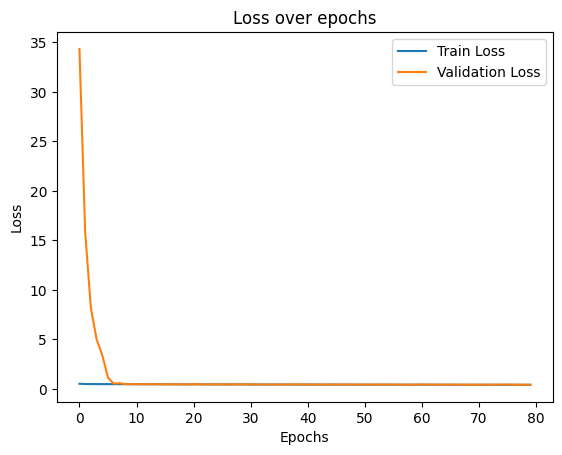

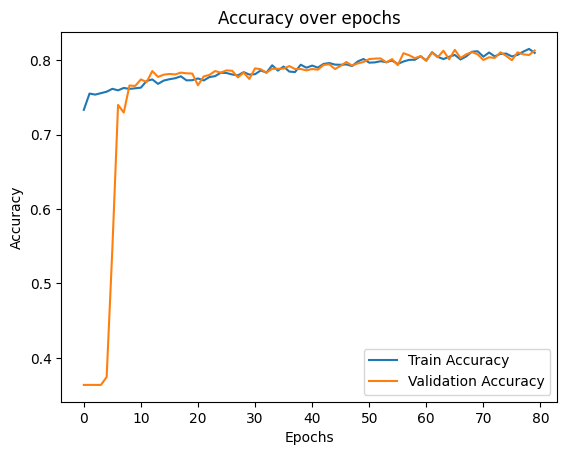

In [36]:
import matplotlib.pyplot as plt

# Loss 曲線
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Accuracy 曲線
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


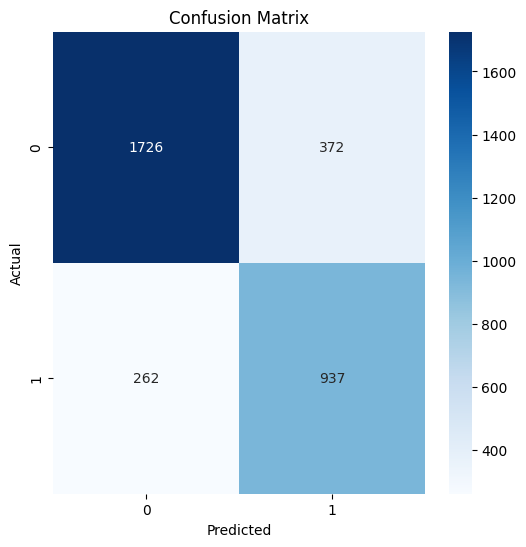

Classification Report:

              precision    recall  f1-score   support

           0     0.8682    0.8227    0.8448      2098
           1     0.7158    0.7815    0.7472      1199

    accuracy                         0.8077      3297
   macro avg     0.7920    0.8021    0.7960      3297
weighted avg     0.8128    0.8077    0.8093      3297



In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 預測結果
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)  # 轉換為二分類結果

# 計算混淆矩陣
cm_a = confusion_matrix(y_test, y_pred_class)

# 繪製混淆矩陣
plt.figure(figsize=(6, 6))
sns.heatmap(cm_a, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_class, digits=4))